In [167]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
# import fuction for chi2 calucaltions
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [162]:
#get the data
file_path = "data/survey.csv"
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [12]:
#Check the total number of missing values
df.columns

Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments'],
      dtype='object')

In [163]:
# adopted from
# https://www.kaggle.com/kairosart/machine-learning-for-mental-health-1
df2=df.copy()
df2['Gender_0']=df2['Gender'].str.lower()
df2['Gender_0'].replace({'male': 'Male', 
                         'male ': 'Male',
                         'female': 'Female', 
                         'female ': 'Female',
                         'f': 'Female', 
                         'm': 'Male', 
                         'make': 'Male', 
                         'woman': 'Female', 
                         'female (cis)': 'Female',
                        'man': 'Male',
                        'mail': 'Male',
                        'maile': 'Male',
                        'male cis': 'Male',
                        'male (cis)': 'Male',
                        'femail': 'Female',
                        'femake': 'Female',
                        'cis female': 'Female',
                        'cis man': 'Male',
                        'cis male': 'Male',
                        'malr': 'Male',
                        'mal': 'Male',
                        'cis-female/femme': 'Female',
                        'msle': 'Male',
                        'male-ish': 'Male',
                        'female (trans)': 'Female',
                        "trans-female": "trans", 
                         "something kinda male?": "trans", 
                         "queer/she/they": "trans", 
                         "non-binary": "trans",
                         "nah": "trans", 
                         "all": "trans", 
                         "enby": "trans", 
                         "fluid": "trans", 
                         "genderqueer": "trans", 
                         "androgyne": "trans", 
                         "agender": "trans", 
                         "male leaning androgynous": "trans", 
                         "guy (-ish) ^_^": "trans", 
                         "trans woman": "trans", 
                         "neuter": "trans", 
                         "female (trans)": "trans", 
                         "queer": "trans", 
                         "ostensibly male, unsure what that really means": "trans"}, inplace=True)

#df2.loc[(df2['Gender_0'] != 'Female') & (df2['Gender_0'] != 'Male'), 'Gender_0'] = None
#Get rid of bullshit
stk_list = ['A little about you', 'p']
df2 = df2[~df2['Gender'].isin(stk_list)]
df2['Gender_0'].describe()

count     1257
unique       3
top       Male
freq       991
Name: Gender_0, dtype: object

In [158]:
#df2['Gender_0']=df2['Gender'].str.lower()
df2['Gender_0'].unique()

array(['Female', 'Male', 'trans'], dtype=object)

In [164]:
#Clean up age
#its good practice to keep the original variables
print(df2['Age'].describe())
df2['Age_0']=df2["Age"]
df2.loc[(df2['Age_0']== -29), "Age_0"] = 29
#complete missing age with median
df2['Age_0'].fillna(df2['Age_0'].median(), inplace=True)

#complete those with <18 and >120 age with median
df2.loc[(df2['Age_0']<18) | (df2['Age_0']>150), "Age_0"]=df2['Age_0'].median()
df2['Age_0'].describe().transpose()

count    1.257000e+03
mean     7.955453e+07
std      2.820541e+09
min     -1.726000e+03
25%      2.700000e+01
50%      3.100000e+01
75%      3.600000e+01
max      1.000000e+11
Name: Age, dtype: float64


count    1257.000000
mean       32.070008
std         7.271675
min        18.000000
25%        27.000000
50%        31.000000
75%        36.000000
max        72.000000
Name: Age_0, dtype: float64

In [169]:
#Add Age group
df2["Age_group"]  = df2["Age_0"]
df2.loc[(df2['Age_0']<=30), "Age_group"]="18 - 30 yrs"
df2.loc[(df2['Age_0']>30), "Age_group"]="Greater than 30 yrs"
df2["Age_group"].value_counts()

Greater than 30 yrs    677
18 - 30 yrs            580
Name: Age_group, dtype: int64

In [165]:
# Check nullity
df2.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
Gender_0                        0
Age_0                           0
dtype: int64

In [211]:
#There are only 8/1257 (1.4%) of self employed so let's change NaN to NOT self_employed
#Replace "NaN"  to No
df2['self_employed_0'] = df2['self_employed'].replace({None:'No'})
print(df2['self_employed_0'].unique())

['No' 'Yes']


In [196]:
#There are only 264/1257 (21%) of work interfere so let's change NaN to "Don't know"
#Replace "NaN"  to "Don't know"
df2['work_interfere_0'] = df2['work_interfere'].replace({None:"Don't know"})
print(df2['work_interfere_0'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


In [176]:
pd.crosstab(df2['Age_group'].fillna('Missing'),df2['Gender_0'].fillna('Missing'))

Gender_0,Female,Male,trans
Age_group,,,
18 - 30 yrs,130,438,12
Greater than 30 yrs,117,553,7


In [177]:
# Check nullity after cleaning the data
df2.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
Gender_0                        0
Age_0                           0
Age_group     

In [213]:
#Number of employees
df2.no_employees.value_counts()
#maybe have just 3 categories
# Since the groups 26 - 100; 100 - 500 and 500- 1000 are mixed up, we can combine this to one single group
df2['no_employees_0'] = df2['no_employees']
df2.loc[(df2.no_employees == "26-100") | (df2.no_employees == "100-500") | (df2.no_employees == "500-1000"), 'no_employees_0'] = "26-1000"
df2.loc[(df2.no_employees == "1-5") | (df2.no_employees == "6-25"), 'no_employees_0'] = "1-25"
df2.no_employees_0.value_counts()

26-1000           525
1-25              450
More than 1000    282
Name: no_employees_0, dtype: int64

In [171]:
#try running the profiler on afew var of interest
columns_of_interest = ['Age_group','Age_0', 'Gender_0', 'Country', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor',
       'mental_vs_physical', 'obs_consequence']
profile = ProfileReport(df2[columns_of_interest], 
                        title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/37 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
#Define some custom functions to help us generate two table using crosstab function
def add_percentage_row(row):
    for r in row.index:
        cell_prop = row[r]/row['Total']*100
        row[r] = "{} ({:.1f}%)".format(row[r], cell_prop)
    return row

#Cerat a function to calcute pavlue from a two-by-two table
def calculate_pvalue(data):
    data2 = data.copy()
    data2.apply(add_percentage_row, axis = 0)
    print("Two way Table")
    print(data2)
    data = data.loc[data.index != "Missing"]
    stat, p, dof, expected = chi2_contingency(data)
    print("Chi2 P-Value {:.3f}".format(p))
    print("\n")
    return 

In [24]:
#Create a two-way table and fill in  missiung values
table = pd.crosstab(df2["Age_group"].fillna("Missing"), df2["treatment"], margins=True, margins_name="Total")
#add Row Percentage
table.apply(add_percentage_row, axis = 1)

#add column Percentage
table.apply(add_percentage_row, axis = 0)

calculate_pvalue(pd.crosstab(df2["Age_group"].fillna("Missing"), df2["treatment"], margins=True, margins_name="Total"))

Two way Table
treatment                     No          Yes         Total
Age_group                                                  
18 - 30 yrs           305 (49.0)   274 (43.0)    579 (46.0)
Greater than 30 yrs   314 (50.5)   358 (56.2)    672 (53.4)
Missing                  3 (0.5)      5 (0.8)       8 (0.6)
Total                622 (100.0)  637 (100.0)  1259 (100.0)
P-Value 0.354


In [214]:
# generate the two - way table for each predictor/rissk factors of MH vs Treatment
# Generate the ch2 p value (Ho = No association btwn the treatment and the preductor/risk factors of MH)
# This is an important step to help us determine what features/predictors end up our final model
features_of_interest = ['Age_group', 'Gender_0', 'self_employed_0',
       'family_history',  'no_employees_0', 'work_interfere_0',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       ]

for feature in features_of_interest:
    table = pd.crosstab(df2[feature].fillna("Missing"), df2["treatment"], margins=True, margins_name="Total")
    calculate_pvalue(table)

Two way Table
treatment                      No           Yes          Total
Age_group                                                     
18 - 30 yrs           306 (49.2%)   274 (43.1%)    580 (46.1%)
Greater than 30 yrs   316 (50.8%)   361 (56.9%)    677 (53.9%)
Total                622 (100.0%)  635 (100.0%)  1257 (100.0%)
Chi2 P-Value 0.328


Two way Table
treatment            No           Yes          Total
Gender_0                                            
Female       77 (12.4%)   170 (26.8%)    247 (19.6%)
Male        541 (87.0%)   450 (70.9%)    991 (78.8%)
trans          4 (0.6%)     15 (2.4%)      19 (1.5%)
Total      622 (100.0%)  635 (100.0%)  1257 (100.0%)
Chi2 P-Value 0.000


Two way Table
treatment                  No           Yes          Total
self_employed_0                                           
No                554 (89.1%)   559 (88.0%)   1113 (88.5%)
Yes                68 (10.9%)    76 (12.0%)    144 (11.5%)
Total            622 (100.0%)  635 (100.0%)  12

In [201]:
# Check out an object with clean dataset
# try dropping null age and gender
# delete all rows for which column 'Age' has value between 30 to 40 
indexNames = df2[(df2['Gender_0'].isnull()) | (df2['Age_0'].isnull()) ].index #get the index of rows of interest
df_analysis = df2.loc[:]
df_analysis.drop(indexNames, inplace = True)
df_analysis.shape

(1257, 32)

In [ ]:
# Add some data visualization btwn treatment and other predictors


In [215]:
#Bulid LR Model to determine the independent risk factors of MH
#import appropriate library
import statsmodels.api as sm
from statsmodels.formula.api import logit
predictors = ['Age_group', 'Gender_0', 
               'family_history', 
               'remote_work',  'care_options',
               'seek_help', 'anonymity', 'leave']

# Set the baseline Values and convert into values that cab takeup by the model
df_analysis['treatment_0'] = df_analysis['treatment'].map({'Yes':1,'No':0})
df_analysis['Age_group_0'] = df_analysis['Age_group'].map({'Greater than 30 yrs':1,'18 - 30 yrs':0})
df_analysis['sex_0'] = df_analysis['Gender_0'].map({'Male':"0_Male",'Female':"1_Female"})
df_analysis['seek_help_0'] = df_analysis['seek_help'].map({'No':"0_No",'Yes':"1_Yes", "Don't know":"2_Don't know"})
df_analysis['leave_0'] = df_analysis['leave'].map({'Very easy':'0_Very easy','Somewhat easy':'1_Somewhat easy', 
                                                   'Somewhat difficult':'2_Somewhat difficult', 
                                                   'Very difficult':"3_Very difficult",
                                                  "Don't know":"4_Don't know"})
df_analysis['benefits_0'] = df_analysis['benefits'].map({'No':'0_No','Yes':'1_Yes', "Don't know":"2_Don't know"})
df_analysis['work_interfere_1']=df_analysis['work_interfere_0'].map({'Often':'0_Often', 'Sometimes': '1_Sometimes', 'Rarely':'2_Rarely', 'Never':'3_Never', "Don't know":"4_Don't know"})

y = df_analysis['treatment_0']
X = df_analysis[predictors]
#formula = ('treatment ~ Age_group + Gender_0 + family_history + remote_work + care_options + seek_help + anonymity + leave')
formula = ('treatment_0 ~ Age_group + sex_0 + family_history + care_options + seek_help_0 + anonymity + benefits_0 + work_interfere_1')
#logit_model=sm.Logit(y,X)
#result=logit_model.fit()
model = logit(formula = formula, data = df_analysis).fit()
print(model.summary())

#Print the odds ratios
print("Odds Scale \n {}".format(np.exp(model.params)))
#print(result.summary2())

#Confidence Intervals in odds scalw=e
print("Confidence Intervals \n {}".format(np.exp(model.conf_int())))

print("Model AIC \n {}".format(model.aic))
#model.params

Optimization terminated successfully.
         Current function value: 0.370722
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            treatment_0   No. Observations:                 1238
Model:                          Logit   Df Residuals:                     1222
Method:                           MLE   Df Model:                           15
Date:                Thu, 22 Jul 2021   Pseudo R-squ.:                  0.4652
Time:                        05:27:21   Log-Likelihood:                -458.95
converged:                       True   LL-Null:                       -858.11
Covariance Type:            nonrobust   LLR p-value:                1.947e-160
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.5566      0.303      1.83

In [180]:
df_analysis.describe()

,Age,Age_0
count,1.257000e+03,1257.000000
mean,7.955453e+07,32.070008
std,2.820541e+09,7.271675
min,-1.726000e+03,18.000000
25%,2.700000e+01,27.000000
50%,3.100000e+01,31.000000
75%,3.600000e+01,36.000000
max,1.000000e+11,72.000000


In [202]:
# Reference https://onezero.blog/modelling-binary-logistic-regression-using-python-research-oriented-modelling-and-interpretation/
# Model Fitting (Binary Logistic Regression)
# The next step is splitting the diabetes data set into train and test split using train_test_split of sklearn.model_selection module 
# and fitting a logistic regression model using the statsmodels package/library.

# Train and Test Split
# The whole data set generally split into 80% train and 20% test data set (general rule of thumb). 
# The 80% train data is being used for model training, while the rest 20% is used for checking how the model generalized on unseen data set.

# Import library to split the data into training and test data as well as fitting LR Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Encode/Formating to allow the model to work simlessly
# Note that the model does not work with string values and there4 these must be encoded for this to work
# The predictors will include only features/variables that showed association with the outcome (MH treatment) except for age
df_analysis['treatment_0'] = df_analysis['treatment'].map({'Yes':1,'No':0})
df_analysis['sex_0'] = df_analysis['Gender_0'].map({'Male':0,'Female':1, "trans":3})
df_analysis['seek_help_0'] = df_analysis['seek_help'].map({'No':0,'Yes':1, "Don't know":2})
df_analysis['family_history_0'] = df_analysis['family_history'].map({'No':0,'Yes':1})
df_analysis['care_options_0'] = df_analysis['care_options'].map({'No':0,'Yes':1, "Not sure":2})
df_analysis['anonymity_0'] = df_analysis['seek_help'].map({'No':0,'Yes':1, "Don't know":2})
df_analysis['benefits_0'] = df_analysis['benefits'].map({'No':0,'Yes':1, "Don't know":2})
df_analysis['Age_group_0'] = df_analysis['Age_group'].map({'Greater than 30 yrs':1,'18 - 30 yrs':0})
df_analysis['leave_0'] = df_analysis['leave'].map({'Very easy':0,'Somewhat easy':1, 
                                                   'Somewhat difficult':2, 
                                                   'Very difficult':3,
                                                  "Don't know":4})

df_analysis['work_interfere_1']=df_analysis['work_interfere_0'].map({'Often':0, 'Sometimes': 1, 'Rarely':2, 'Never':3, "Don't know":4})
# Fitting Logistic Regression
feature_cols = ['Age_group_0', 'sex_0', 'family_history_0' , 'benefits_0' , 'care_options_0' ,  'anonymity_0', 'leave_0', 'work_interfere_1']


# Features/Predictors
df_analysis2 = df_analysis[feature_cols]
#Outcome/Dependent Variable
y = df_analysis['treatment_0']
train_data, test_data, train_y, test_y = train_test_split(df_analysis2, y, test_size=0.20, random_state=1)

# instantiate the model (using the default parameters)
model = LogisticRegression() 

# fit the model with data
model.fit(train_data, train_y)
#print(model.summary())

# predict Model
y_pred=model.predict(test_data)

# Model Evaluation using Confusion Matrix
cnf_matrix = metrics.confusion_matrix(test_y, y_pred)
cnf_matrix


array([[ 92,  34],
       [ 13, 113]])

In [198]:
df_analysis2.isnull().sum()

Age_group_0            0
sex_0                  0
family_history_0       0
benefits_0             0
care_options_0         0
anonymity_0            0
leave_0                0
work_interfere_1    1257
dtype: int64

Text(0.5, 257.44, 'Predicted label')

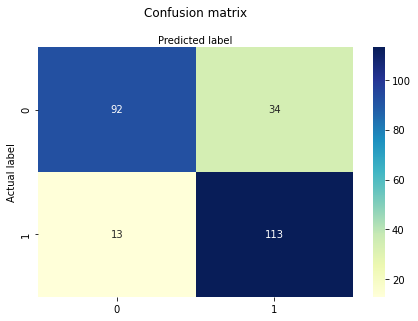

In [203]:
# Visualizing Confusion Matrix using Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [204]:
# Confusion Matrix Evaluation Metrics
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))
print("Precision:",metrics.precision_score(test_y, y_pred))
print("Recall:",metrics.recall_score(test_y, y_pred))

Accuracy: 0.8134920634920635
Precision: 0.7687074829931972
Recall: 0.8968253968253969


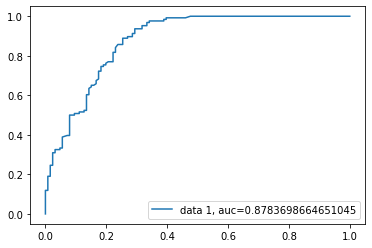

In [205]:
# ROC Curve
# Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.
y_pred_proba = model.predict_proba(test_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_y,  y_pred_proba)
auc = metrics.roc_auc_score(test_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()